## Surface Determination Workflow  

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
from tomo_encoders import Patches, DataFile
import tensorflow as tf
import time, glob
import open3d as o3d

sys.path.append('/data02/MyArchive/aisteer_3Dencoders/TomoEncoders/scratchpad/surface_determination/trainer')
from tomo_encoders.neural_nets.surface_segmenter import SurfaceSegmenter
from tomo_encoders.misc.feature_maps_vis import view_midplanes
from tomo_encoders.misc.voxel_processing import normalize_volume_gpu
from tomo_encoders.misc.viewer import view_midplanes, add_scalebar, edge_plot
from tqdm import tqdm


In [2]:
gt_path = '/data02/MyArchive/tomo_datasets/ZEISS_try2/GT_VOLS/Sample2'
ct_path = '/data02/MyArchive/tomo_datasets/ZEISS_try2/Sample2_CT'
psize = (16,16,16)
size_lab = '16x16'

In [3]:
ds_gt = DataFile(gt_path, tiff = True, VERBOSITY = 0)
vol_gt = ds_gt.read_full()

In [4]:
p = Patches(None, initialize_by = 'file', fpath = f'/data02/MyArchive/tomo_datasets/ZEISS_try2/sample2_edge_patches_{size_lab}.hdf5')
y_true = p.extract(vol_gt, psize)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

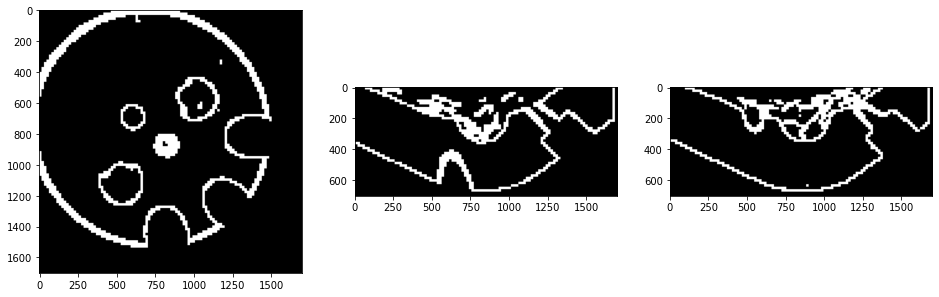

In [5]:
vol_out = np.zeros(p.vol_shape)
vols = np.ones((len(p),) + psize)
p.fill_patches_in_volume(vols, vol_out)
fig, ax = plt.subplots(1,3, figsize = (16,8))
view_midplanes(vol_out, ax = ax)

## Measure IoU in datasets

In [6]:
from tomo_encoders.misc.img_stats import calc_SNR, calc_jac_acc, calc_dice_coeff
from tomo_encoders import DataFile
import pandas as pd

In [7]:
ct_path_dr10x = '/data02/MyArchive/tomo_datasets/ZEISS_try2/Sample2_CT/DR10X'
ct_path_fdk10x = '/data02/MyArchive/tomo_datasets/ZEISS_try2/Sample2_CT/FDK10X'
ct_path_fdk1x = '/data02/MyArchive/tomo_datasets/ZEISS_try2/Sample2_CT/FDK1X'

In [24]:
seg_path_dr10x = '/data02/MyArchive/tomo_datasets/ZEISS_try2/Sample2_SEG/DR10X_M_a03'
seg_path_fdk10x = '/data02/MyArchive/tomo_datasets/ZEISS_try2/Sample2_SEG/FDK10X_M_a03'
seg_path_fdk1x = '/data02/MyArchive/tomo_datasets/ZEISS_try2/Sample2_SEG/FDK1X_M_a03'

In [8]:
vol_dr10x = DataFile(ct_path_dr10x, tiff = True, VERBOSITY = 0).read_full()
vol_fdk10x = DataFile(ct_path_fdk10x, tiff = True, VERBOSITY = 0).read_full()
vol_fdk1x = DataFile(ct_path_fdk1x, tiff = True, VERBOSITY = 0).read_full()

In [25]:
seg_dr10x = DataFile(seg_path_dr10x, tiff = True, VERBOSITY = 0).read_full()
seg_fdk10x = DataFile(seg_path_fdk10x, tiff = True, VERBOSITY = 0).read_full()
seg_fdk1x = DataFile(seg_path_fdk1x, tiff = True, VERBOSITY = 0).read_full()

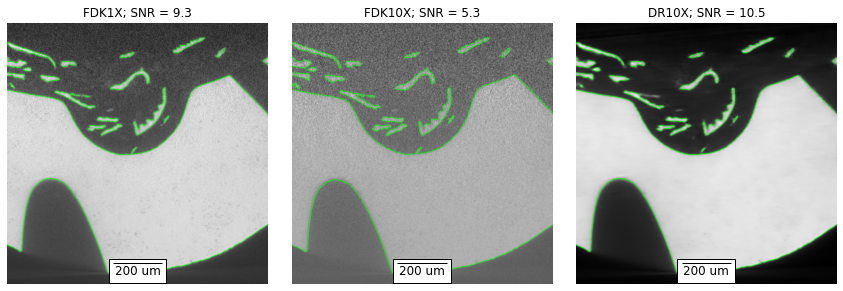

In [36]:
fig, ax = plt.subplots(1,3, figsize = (12,4))

edge_plot(vol_fdk1x[:,850,500:-500], seg_fdk1x[:,850,500:-500], ax[0])
edge_plot(vol_fdk10x[:,850,500:-500], seg_fdk10x[:,850,500:-500], ax[1])
edge_plot(vol_dr10x[:,850,500:-500], seg_dr10x[:,850,500:-500], ax[2])

SNRs = [9.3,5.3, 10.5]
labs = ["FDK1X", "FDK10X", "DR10X"]
for i in range(3):
    ax[i].axis('off')
    add_scalebar(ax[i], 200, 1.51, fontsize = 12)
    ax[i].set_title(f"{labs[i]}; SNR = {SNRs[i]}", fontsize = 12)
    
fig.tight_layout()